<H1>Scraping Bachelor Wikipedia Episode Tables and Reddit Data for Viewer Prediction</H1>
pyBach is a collection of functions that allows for scraping of bachelor and bachelorette data from Wikipedia and Reddit

In [ ]:
#Using https://www.tensorflow.org/tutorials/keras/basic_regression as template NN-regression analysis
import pyBach #my module
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<ul>
<li>First scrape last 5 season of The Bachelor and The Bachelorette into a pandas dataframe</li>
    <li>Join all individual dataframes into one large dataframe</li>
    <li>Reset the dataframe index</li>

In [ ]:
dfList = []
bachSeasons = range(19,24)
etteSeasons = range(10,15)

for bachSeason in bachSeasons:
    dfList.append(pyBach.scrapeWikiEpiTable(bachSeason))
for etteSeason in etteSeasons:
    dfList.append(pyBach.scrapeWikiEpiTable(etteSeason, show='bachelorette'))

df = pd.concat(dfList)
df.reset_index(drop=True, inplace=True)

In [ ]:
sns.pairplot(df[['isBachelor', 'numOverall', 'numInSeason', 'season', 'year', 'viewers(millions)']], diag_kind="kde")

## Scrape all submission titles and all comments from the week leading up to the episode
This part of the module performs two tasks
<ol>
    <li>Counts the total number of submisisons(AKA posts) and total number of comments in the 'TheBachelor' subreddit the week before the episode airs</li>
        <li>Performs VADER (Valence Aware Dictionary and sEntiment Reasoner) analysis on each submission title and comment text. The individual text gets a single compound score, with -1 being most negative, and 1 being most positive.</li>

In [ ]:
#dfTotal = pyBach.appendRedditStats(df)
dfTotal = pd.read_pickle('dfTotal.pickle')
dfTotal.reset_index(drop=True, inplace=True)
dfTotal

In [ ]:
sns.pairplot(dfTotal[['isBachelor', 'numOverall', 'numInSeason', 
                     'season', 'year', 'subNum', 'commentNum', 'viewers(millions)']], diag_kind="kde")

In [ ]:
sns.pairplot(dfTotal[['year', 'subNum', 'commentNum', 
                     'meanTitleSentiment', 'stdTitleSentiment', 
                     'meanCommentSentiment', 'stdCommentSentiment','viewers(millions)']], diag_kind="kde")

# Examine performance of multilayer Perceptron using Episode data alone, Reddit counts, and Reddit sentiment analysis
## Create list of lists of features

In [ ]:
#establish feature subsets
featureLists = []
featureLists.append(['isBachelor', 'viewers(millions)'])
featureLists.append(['isBachelor', 'numOverall', 'numInSeason', 
                     'season', 'year', 'viewers(millions)'])
featureLists.append(['isBachelor', 'numOverall', 'numInSeason', 
                     'season', 'year', 'subNum', 'commentNum', 'viewers(millions)'])
featureLists.append(['isBachelor', 'numOverall', 'numInSeason', 
                     'season', 'year', 'subNum', 'commentNum', 
                     'meanTitleSentiment', 'stdTitleSentiment', 
                     'meanCommentSentiment', 'stdCommentSentiment','viewers(millions)'])
featureLists.append(dfTotal.columns)
print(dfTotal.columns)

## Split the total date into train, test, and cross-validation sets
60% in train, 20% in test, and 20% in cross-validation sets

In [ ]:
dfTrainAll, dfTestAll, dfCVAll = pyBach.splitDfs(dfTotal, rsInt=0)

In [ ]:
#Instantiate lists to keep trained models and scalers for normalizing data
testLosses = []
cvLosses = []
models = [];
scalers = [];
#Train the models on subsets of features
for features in featureLists:
    dfTrain = dfTrainAll[features]
    dfCV = dfCVAll[features]
    trainLabels = dfTrain['viewers(millions)']
    scaler, model = pyBach.trainNN(dfTrain)
    #collect models
    models.append(model)
    #collect scalers, probably not necessary...
    scalers.append(scaler)
    #pop off dfCV labels
    cvLabels = dfCV.pop('viewers(millions)')
    #normalized dfCV using scaler
    trainNorm = scaler.transform(dfTrain)
    cvNorm = scaler.transform(dfCV)
    testLoss, _, _ = model.evaluate(trainNorm, trainLabels, verbose=0)
    cvLoss, _, _ = model.evaluate(cvNorm, cvLabels, verbose=0)
    testLosses.append(testLoss)
    cvLosses.append(cvLoss)

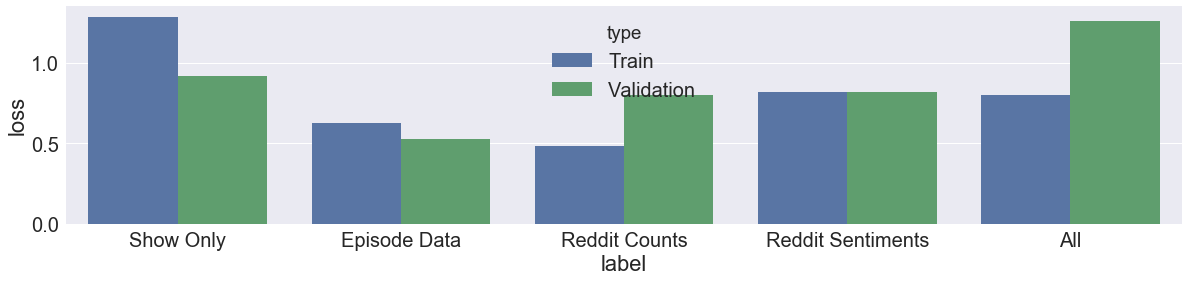

In [13]:
labelList = ['Show Only', 'Episode Data', 'Reddit Counts', 'Reddit Sentiments', 'All']
zippedList = list(zip(testLosses + cvLosses,
                      ['Train']*len(testLosses) + ['Validation']*len(cvLosses),
                      labelList + labelList))

# Create a dataframe from zipped list
dfObj = pd.DataFrame(zippedList, columns = ['loss' , 'type', 'label'],) 
fig, ax = plt.subplots()
fig.set_figwidth(20)
sns.barplot(x='label', y='loss', hue='type', data=dfObj, ax=ax)
